In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

print('=3')

=3


아래 코드를 통해서 KITTI 데이터셋을 다운로드해 주세요. 상당히 오랜 시간이 필요합니다.

In [2]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

print('=3')

=3


다운로드한 KITTI 데이터셋을 `tfds.show_examples`를 통해 보도록 합시다. 우리가 일반적으로 보는 사진보다 광각으로 촬영되어 다양한 각도의 물체를 확인할 수 있습니다.

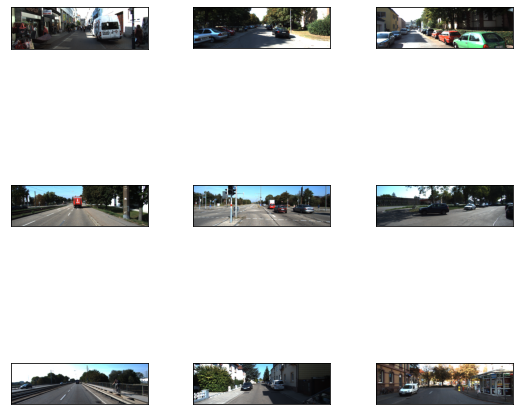

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 `ds_info`에서는 불러온 데이터셋의 정보를 확인할 수 있습니다. 오늘 사용할 데이터셋은 6,347개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있습니다. 라벨에는 `alpha`, `bbox`, `dimensions`, `location`, `occluded`, `rotation_y`, `truncated` 등의 정보가 있습니다.

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

# 8-3. 자율주행 보조장치 (2) 데이터 직접 확인하기
이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠습니다. `ds_train.take(1)`을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 `sample`을 얻을 수 있습니다. 이렇게 뽑은 데이터에는 `image` 등의 정보가 포함되어 있습니다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해 봅시다.

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([ 2.21,  1.87,  1.91,  1.83, -1.29], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.00266667, 0.        , 0.28776   , 0.27582932],
       [0.28112   , 0.34268117, 0.5114933 , 0.45289856],
       [0.36208   , 0.42539454, 0.52066666, 0.49668276],
       [0.40597335, 0.48729467, 0.52085334, 0.5390821 ],
       [0.49637333, 0.64717394, 0.56498665, 0.68178743]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.96, 1.81, 2.58],
       [1.51, 1.63, 4.03],
       [1.57, 1.44, 3.6 ],
       [1.47, 1.51, 3.5 ],
       [1.77, 1.75, 4.67]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-3.41,  1.79,  5.13],
       [-2.26,  1.74, 14.92],
       [-1.04,  1.79, 21.1 ],
       [ 1.04,  1.73, 26.57],
       [15.59,  1.12, 52.14]], dtype=float32)>, 'oc

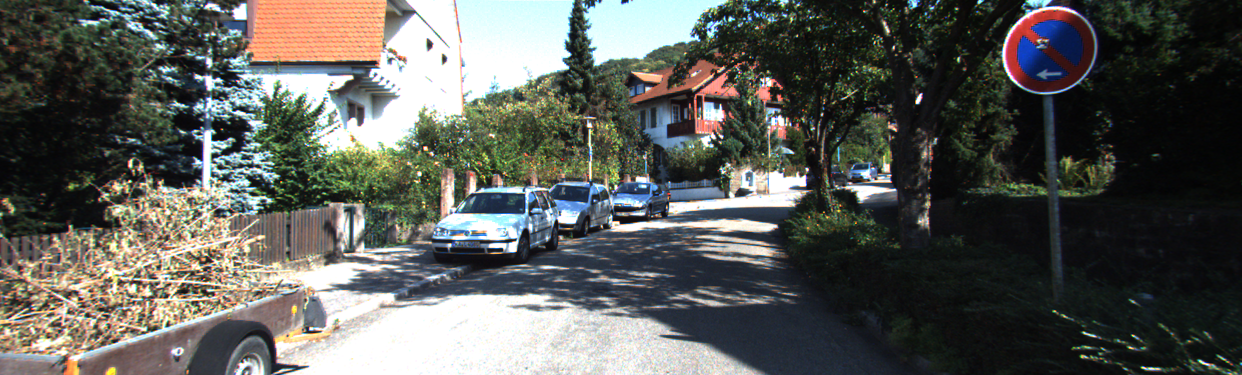

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(5, 4)
[  0.      374.      342.58002 267.09   ]
[425.61002 269.58002 562.5     183.19   ]
[528.34 239.22 616.88 179.75]
[605.22 222.76 669.54 179.68]
[803.79004 188.86    846.77997 163.13   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F03A25F5650>


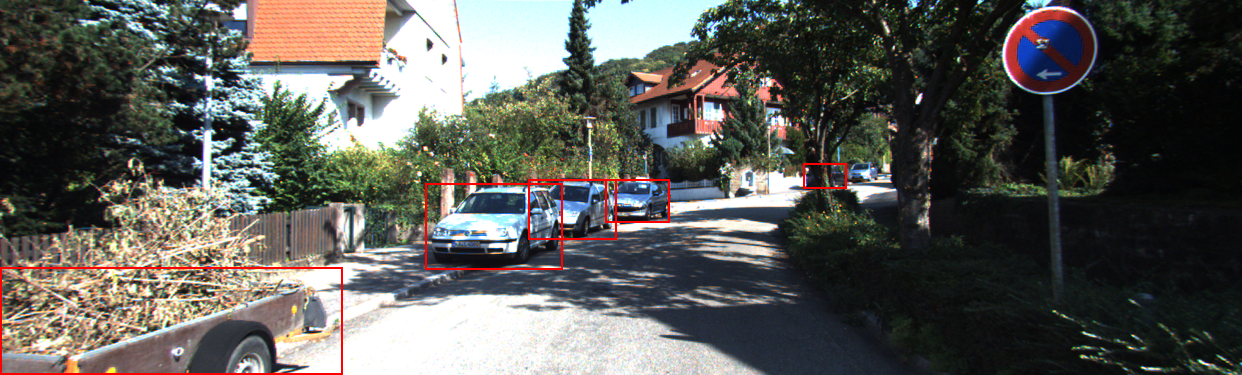

In [6]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [7]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            
    return df
        
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [22:26<00:00,  4.71it/s]


테스트 데이터셋에 대해서도 동일하게 `parse_dataset()` 을 적용해서 dataframe을 생성해 봅시다.

In [8]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:35<00:00,  4.56it/s]


## 클래스 맵핑
데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 합니다. 이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있습니다.

아래 형식을 참고하여, 자동차와 사람을 구별하기 위한 클래스 맵핑 함수를 만들어 주세요.

```python
class_name,id

#Example
cow,0
cat,1
bird,2
```

In [9]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            
save_class_format(class_txt_path)

Done


# 8-6. keras-retinanet 실습 (2) 셋팅
먼저 터미널을 열어주세요. 미리 설치해 둔 케라스 및 Keras RetinaNet 리포지토리를 사용하겠습니다.

아직 설치하지 않으셨다면, 0번 스텝의 '준비물' 항목을 참고하여 환경을 셋팅해 주세요.

준비가 완료되었다면 아래 스크립트를 참고하셔서 위에서 변환한 데이터셋으로 학습을 시작해 주세요. 학습이 잘 되기 위해서는 환경에 따라 `batch_size`나 `worker`, `epoch`를 조절해야 합니다.

훈련 이미지 크기 또는 `batch_size`가 너무 크면 GPU에서 out-of-memory 에러가 날 수 있으니 적절히 조정해 주세요. 원 개발자는 8G 메모리도 RetinaNet을 훈련시키기에는 부족할 수 있다고 설명합니다 ([참고](https://github.com/fizyr/keras-retinanet/issues/499)).

In [10]:
# RetinaNet 훈련이 시작됩니다!! 10epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-10-18 01:03:44.247087: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Traceback (most recent call last):
  File "keras-retinanet/keras_retinanet/bin/train.py", line 38, in <module>
    from ..callbacks.eval import Evaluate
  File "keras-retinanet/keras_retinanet/bin/../../keras_retinanet/callbacks/eval.py", line 18, in <module>
    from ..utils.eval import evaluate
  File "keras-retinanet/keras_retinanet/bin/../../keras_retinanet/utils/eval.py", line 26, in <module>
    import progressbar
ModuleNotFoundError: No module named 'progressbar'
Done


아래 코드를 사용해 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환합시다.

In [13]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-10-18 01:08:25.450588: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-18 01:08:26.999137: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-18 01:08:27.000094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-18 01:08:27.008151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-18 01:08:27.008196: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-18 01:08:27.011602: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-18

In [14]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


결과를 확인해 볼 함수를 만듭시다.

In [15]:
# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            



[188.66316 132.31973 347.36475 235.9846 ]
[593.3867  176.83397 625.48535 207.18364]
[376.70123 182.8373  418.56995 212.04446]
[530.7206  160.03726 566.4948  192.3531 ]
[440.97922 176.07349 472.3364  201.46313]


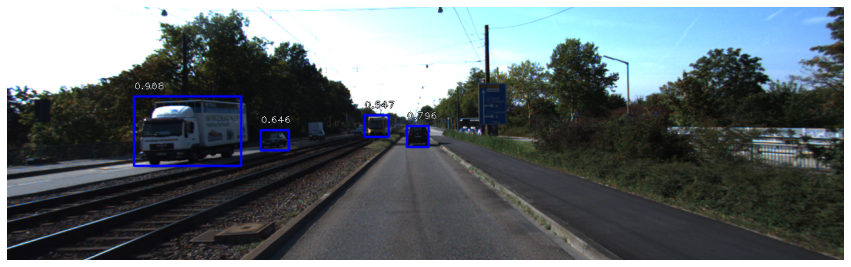

In [17]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'
inference_on_image(model, img_path)

다른 이미지도 확인해 봅시다.

[765.54333 146.52757 840.0525  319.2644 ]
[739.75616 138.34695 828.23804 282.34283]


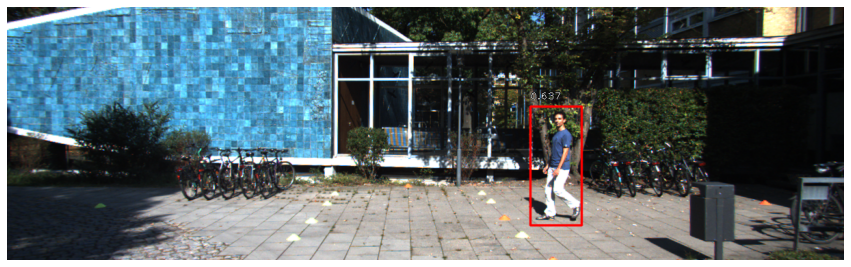

In [18]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

# 8-8. 프로젝트: 자율주행 보조 시스템 만들기
## 1. 자율주행 시스템 만들기
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
 - 사람이 한 명 이상 있는 경우
 - 차량의 크기(width or height)가 300px이상인 경우


In [20]:
def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        print(box)
        if score < 0.5:
            break
        b = box.astype(int)
        width = b[2]-b[0]
        height = b[3]-b[1]
        
        if width >= size_limit or height >= size_limit or label == 1:
            # 차량의 크기(width or height)가 300px이상 or 라벨이 사람
            result = 'Stop'
        else:
            result = 'Go'
            
        draw_box(draw, b, color=color_map[label])

        caption = "{:.3f}".format(score)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()   
    
    return result

[  0.      191.23094 287.16278 369.12827]
[756.0324  161.43993 869.99304 211.6869 ]
[ 991.5309   152.05608 1030.252    213.75082]
[ 986.1042   147.93463 1030.9565   215.94357]


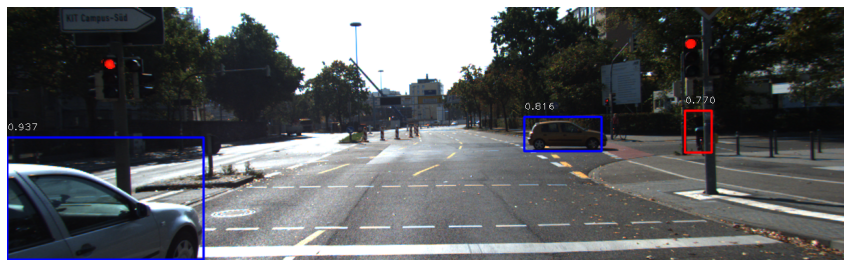

'Stop'

In [22]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_3.png'
self_drive_assist(img_path=img_path)

## 2. 자율주행 시스템 평가하기
아래 `test_system()` 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

[765.54333 146.52757 840.0525  319.2644 ]
[739.75616 138.34695 828.23804 282.34283]


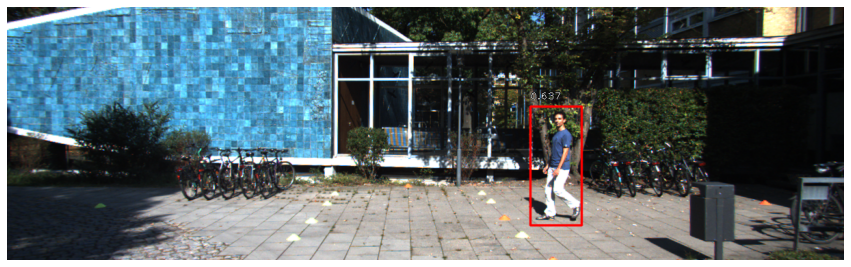

[411.0693  161.10048 488.90695 333.12213]
[390.38354 140.93938 472.24588 306.8117 ]


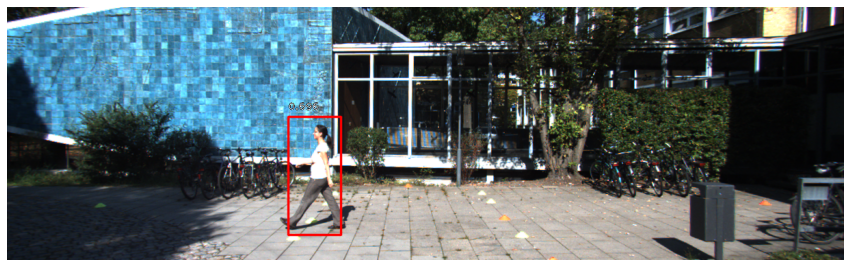

[  0.      191.23094 287.16278 369.12827]
[756.0324  161.43993 869.99304 211.6869 ]
[ 991.5309   152.05608 1030.252    213.75082]
[ 986.1042   147.93463 1030.9565   215.94357]


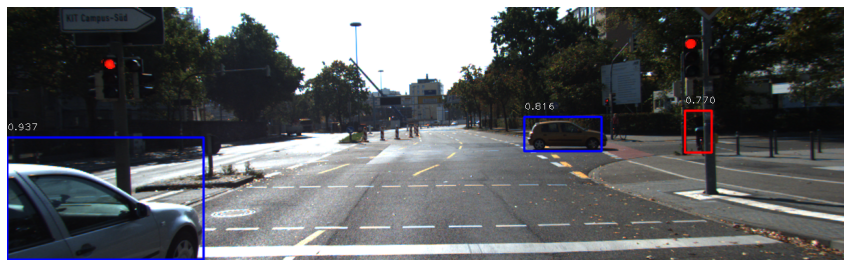

[655.5959  139.74959 735.9075  224.30232]
[438.80505 162.45485 547.75903 208.06529]
[ 40.10736 149.09529 362.41052 323.45517]
[ 746.45245    76.313255 1108.5515    350.41492 ]
[355.3728  171.85382 476.2323  220.75264]
[391.29654 168.8239  519.8865  215.14268]
[724.00745 149.49562 988.7893  360.02582]
[665.67865 144.95111 779.56366 252.31288]


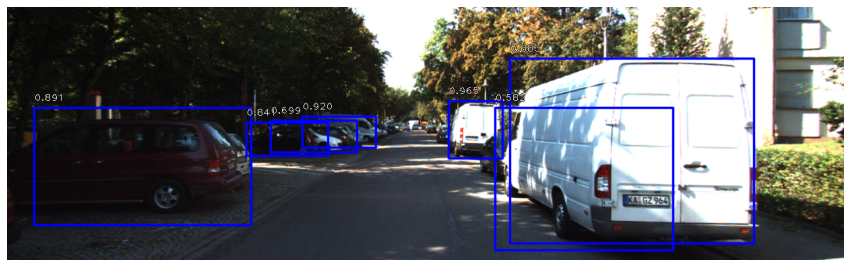

[ 889.7653   170.38577 1241.0684   373.6249 ]
[699.18713 144.92842 775.20355 214.65259]
[566.1093  180.22865 617.8575  216.66174]
[736.7289  163.97235 854.5139  250.73978]
[711.5471  151.79572 817.2522  232.0134 ]
[691.5406  154.69711 748.8717  207.084  ]
[467.9431  174.4527  520.3075  225.38551]


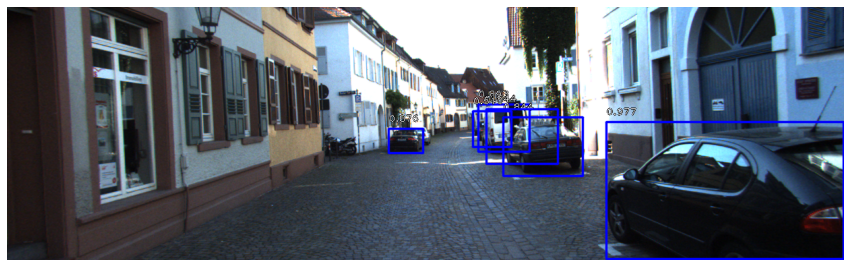

[188.66316 132.31973 347.36475 235.9846 ]
[593.3867  176.83397 625.48535 207.18364]
[376.70123 182.8373  418.56995 212.04446]
[530.7206  160.03726 566.4948  192.3531 ]
[440.97922 176.07349 472.3364  201.46313]


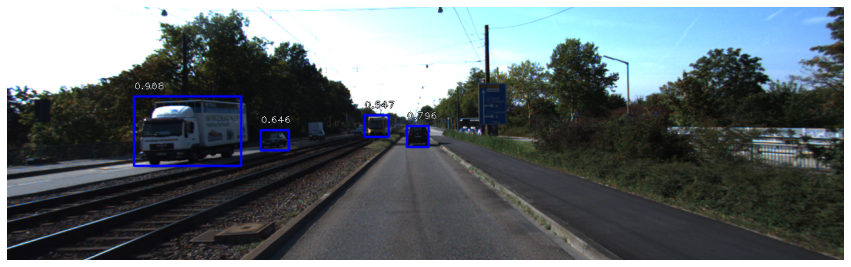

[516.66437 176.52438 567.34595 216.99011]
[627.8889  175.56206 667.6252  214.57716]
[533.21497 174.86613 580.3756  209.65317]


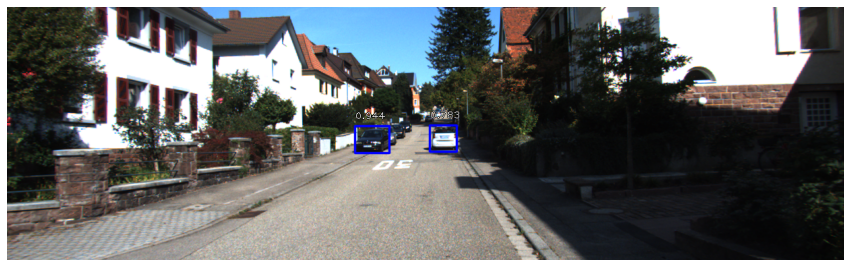

[822.3509  145.28621 886.6169  179.6252 ]
[326.45215 146.81355 393.84955 188.13864]
[  0.       176.10768   49.507744 228.8421  ]
[ 12.672311 176.4211    80.41984  217.0503  ]


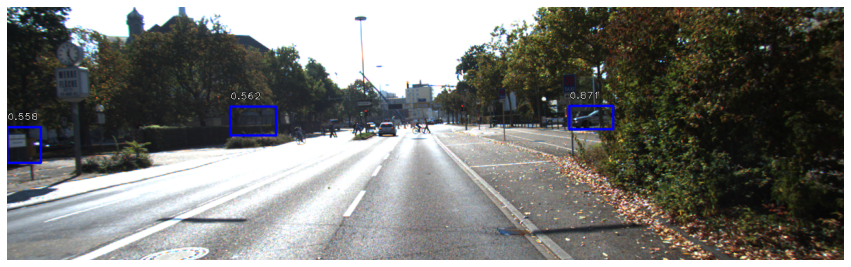

[692.6465  169.76654 790.6705  257.65503]
[732.113     25.617321 782.6091    73.8996  ]


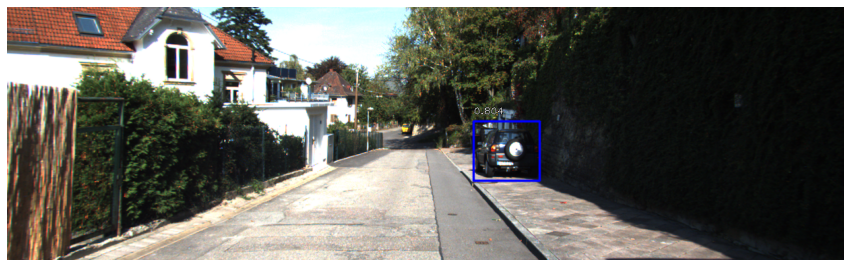

[  4.2710743 184.55345   229.0708    314.95828  ]
[151.3028  178.69185 343.80807 262.92227]
[311.63113 176.32874 422.42764 224.68846]
[436.4965  177.58083 490.05902 210.57773]
[ 44.752598 180.47888  316.09833  276.787   ]
[264.96838 180.77242 380.73276 230.26166]
[808.85394 156.70683 886.91205 193.79868]
[897.02924 145.74094 989.04565 185.3453 ]
[216.72243 180.09167 365.2597  245.67574]
[357.7851  176.74614 444.78696 219.93655]
[ 924.4839   143.92825 1014.87787  180.67377]


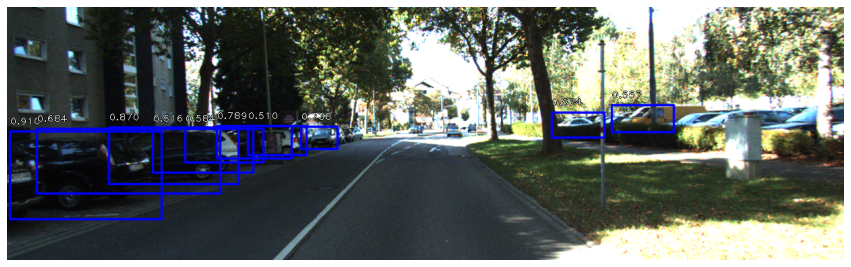

80점입니다.


In [23]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)